In [ ]:
# Load and read our company_hierarchy.csv and employee.csv file
import pandas as pd

company_hierarchy = pd.read_csv('company_hierarchy.csv')
employee = pd.read_csv('employee.csv')
print(company_hierarchy.head())
print(employee.head())

   employee_id   boss_id   dept
0        46456  175361.0  sales
1       104708   29733.0     HR
2       120853   41991.0  sales
3       142630  171266.0     HR
4        72711  198240.0  sales
   employee_id  signing_bonus    salary degree_level sex  yrs_experience
0       138719              0  273000.0       Master   M               2
1         3192              0  301000.0     Bachelor   F               1
2       114657              0  261000.0       Master   F               2
3        29039              0   86000.0  High_School   F               4
4       118607              0  126000.0     Bachelor   F               3


In [ ]:
# EDA
print(company_hierarchy.describe(include="all"))
print(employee.describe(include="all"))

          employee_id        boss_id   dept
count    10000.000000    9999.000000  10000
unique            NaN            NaN      5
top               NaN            NaN  sales
freq              NaN            NaN   3599
mean    100001.855800  103299.980498    NaN
std      57500.488641   57508.798817    NaN
min         40.000000      79.000000    NaN
25%      50574.500000   55883.000000    NaN
50%      99244.500000  102712.000000    NaN
75%     149748.500000  152288.000000    NaN
max     199956.000000  199950.000000    NaN
          employee_id  signing_bonus         salary degree_level    sex  \
count    10000.000000   10000.000000   10000.000000        10000  10000   
unique            NaN            NaN            NaN            4      2   
top               NaN            NaN            NaN          PhD      M   
freq              NaN            NaN            NaN         2822   6439   
mean    100001.855800       0.301400  189111.800000          NaN    NaN   
std      57500.488641 

First step is to categorize employees based the level they have reached in the company. There are six levels within the company:
Individual Contributors (IC): Employees who do not manage anyone.
Middle Managers (MM): Direct supervisors of ICs.
Directors (D): Direct supervisors of MMs.
Vice Presidents (VP): Direct supervisors of Directors.
Executives (E): Direct supervisors of VPs.
CEO: Direct supervisor of Executives.

We can find these levels by identifing the CEO and working down from the top

In [ ]:
# Create a new column in company_hierarchy called employee_level and assign everyone the level 'IC'
company_hierarchy["employee_level"] = "IC"

# Indentify the CEO from the company_hierarchy data frame, the only record with a NULL boss_id and dept = "CEO"
ceo = company_hierarchy[company_hierarchy["boss_id"].isnull() & (company_hierarchy["dept"] == "CEO")]
print("CEO:", ceo)
# Employee_id 61554 is our CEO

# Define our empolyee hierarchy
company_level = ["CEO", "E", "VP", "D", "MM"]

# Define CEO
company_hierarchy.loc[company_hierarchy["employee_id"] == 61554, "employee_level"] = "CEO"

# Build a function that assigns one of our six company_levels to each record starting with the CEO and working down
for i in range(1, len(company_level)):
    # Find IDs of bosses at the level above
    boss_ids = company_hierarchy.loc[company_hierarchy["employee_level"] == company_level[i-1], "employee_id"]
    # Assign current level to those who report to them
    company_hierarchy.loc[company_hierarchy["boss_id"].isin(boss_ids), "employee_level"] = company_level[i]

# Optional: View the hierarchy
print("\n", company_hierarchy.head())
print("\nEmployee Counts:", company_hierarchy["employee_level"].value_counts())

CEO:       employee_id  boss_id dept employee_level
2427        61554      NaN  CEO             IC

    employee_id   boss_id   dept employee_level
0        46456  175361.0  sales             IC
1       104708   29733.0     HR             IC
2       120853   41991.0  sales             IC
3       142630  171266.0     HR             MM
4        72711  198240.0  sales             IC

Employee Counts: employee_level
IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: count, dtype: int64


Out of our 10,000 employees we have the following 90% in IC, 8% in MM, 1.6% in D. 0.35% in VP and only 4 E and 1 CEO

In [ ]:
# Find the number of employees each mananger has under them

# Build a reverse tree from employee -> boss
tree = company_hierarchy[["employee_id", "boss_id"]].copy()

# Initialize a dictionary to hold total reports for each employee
from collections import defaultdict, deque

# Step 1: Create a manager-to-subordinate mapping
manager_map = defaultdict(list)
for _, row in tree.iterrows():
    if not pd.isna(row["boss_id"]):
        manager_map[int(row["boss_id"])].append(int(row["employee_id"]))

# Step 2: Use DFS to compute total reports
def count_reports(emp_id):
    if emp_id not in manager_map:
        return 0
    total = 0
    for sub in manager_map[emp_id]:
        total += 1 + count_reports(sub)  # count direct + indirect reports
    return total

# Step 3: Create the new column
company_hierarchy["total_reports"] = company_hierarchy["employee_id"].apply(count_reports)

# Preview result
print(company_hierarchy[["employee_id", "employee_level", "total_reports"]].head())

# Print the data frame with order by total_reports desc, don't include values of 0
print(company_hierarchy[company_hierarchy["total_reports"] > 0].sort_values(by="total_reports", ascending=False))


   employee_id employee_level  total_reports
0        46456             IC              0
1       104708             IC              0
2       120853             IC              0
3       142630             MM             16
4        72711             IC              0
      employee_id   boss_id         dept employee_level  total_reports
2427        61554       NaN          CEO            CEO           9999
1310        11277   61554.0        sales              E           3598
2778        51535   61554.0  engineering              E           2695
1009       110464   61554.0    marketing              E           2009
9640        93708   61554.0           HR              E           1693
...           ...       ...          ...            ...            ...
4242       166653  146629.0  engineering             MM              4
3032       165668  140317.0  engineering             MM              3
5337       133858  184512.0  engineering             MM              3
5392       172947  1

The next step is to build a model to predict salary but first I want to do a little more exploritory data analysis to help with building the model.

Average Salary by Sex: sex
F    171314.518394
M    198954.340736
Name: salary, dtype: float64


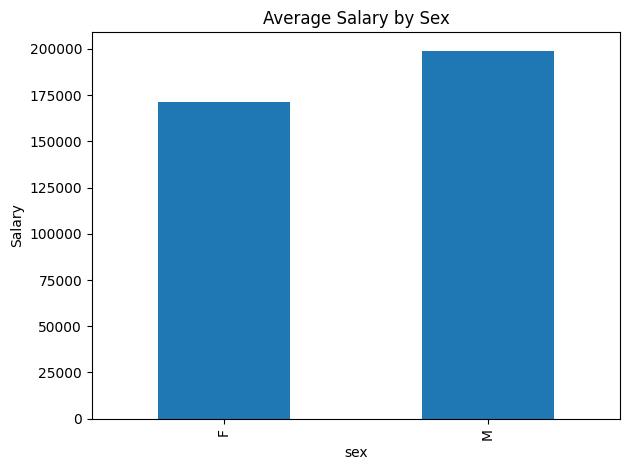


Average Salary per Department:
 dept
CEO            700000.000000
engineering    243524.851632
marketing      194623.383085
sales          194342.039455
HR              84560.212515
Name: salary, dtype: float64


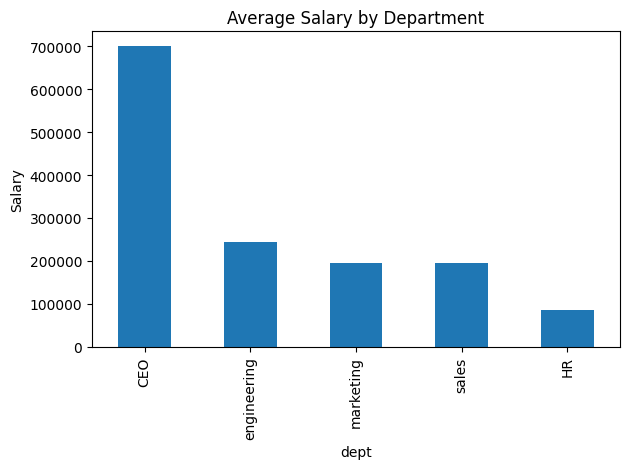


Average Salary by Employee Level:
 employee_level
CEO    700000.000000
E      562500.000000
VP     258028.571429
D      212343.750000
MM     192473.750000
IC     187909.222222
Name: salary, dtype: float64


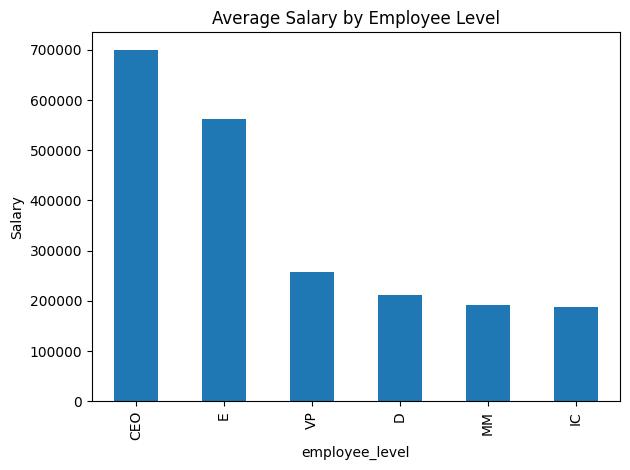


Average Salary per Degree Level:
 degree_level
PhD            191803.685330
Master         188144.651831
High_School    188089.318045
Bachelor       187938.939671
Name: salary, dtype: float64


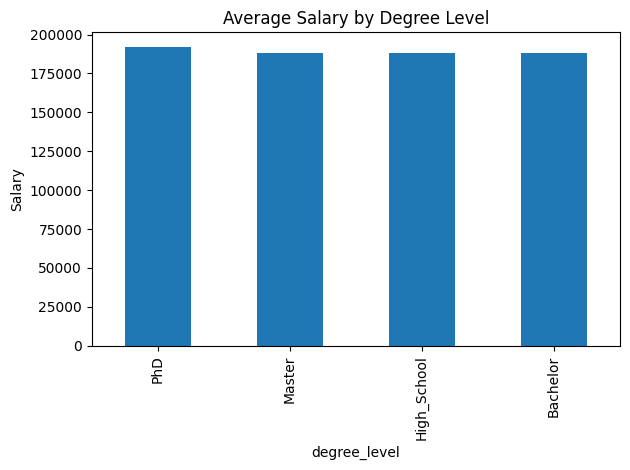


Average Salary per Years of Experience:
 yrs_experience
28    500000.000000
33    459000.000000
34    380000.000000
30    344500.000000
22    308857.142857
32    292500.000000
26    286750.000000
21    268750.000000
15    238166.666667
27    237500.000000
16    230727.272727
18    220538.461538
14    219568.965517
23    217500.000000
19    217142.857143
24    204875.000000
13    198246.153846
9     194880.239521
7     190684.563758
3     189833.427124
4     189303.140979
6     188670.713202
2     188497.883598
1     186785.416667
5     186326.434619
20    185909.090909
10    185402.597403
17    184500.000000
8     184138.576779
11    181736.111111
12    181666.666667
Name: salary, dtype: float64


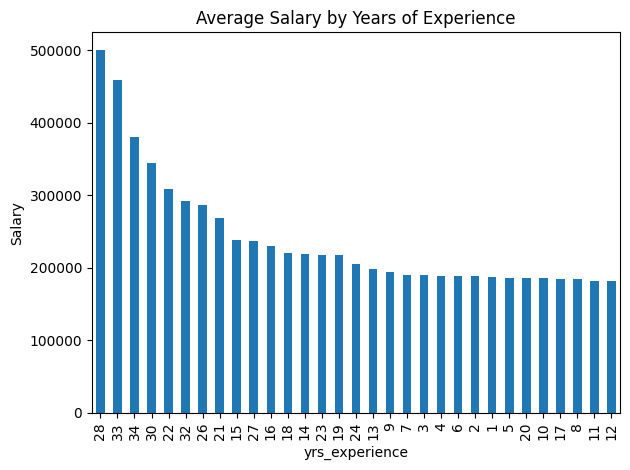


Percentage of Male versus Female employees per Department:
 dept         dept         sex
CEO          CEO          M      100.000000
HR           HR           F       62.455726
                          M       37.544274
engineering  engineering  F       24.888724
                          M       75.111276
marketing    marketing    F       32.388060
                          M       67.611940
sales        sales        F       32.814671
                          M       67.185329
dtype: float64


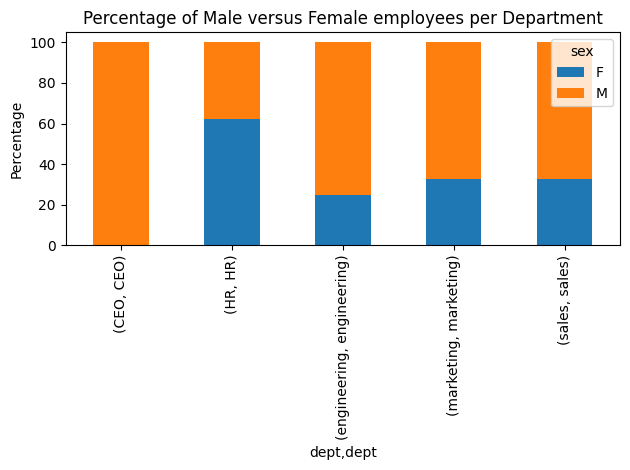

                          mean  count
dept        sex                      
HR          F     84399.810964   1058
            M     84827.044025    636
engineering F    246785.394933    671
            M    242444.444444   2025
marketing   F    192502.304147    651
            M    195639.440765   1359
sales       F    194618.120237   1181
            M    194207.196030   2418


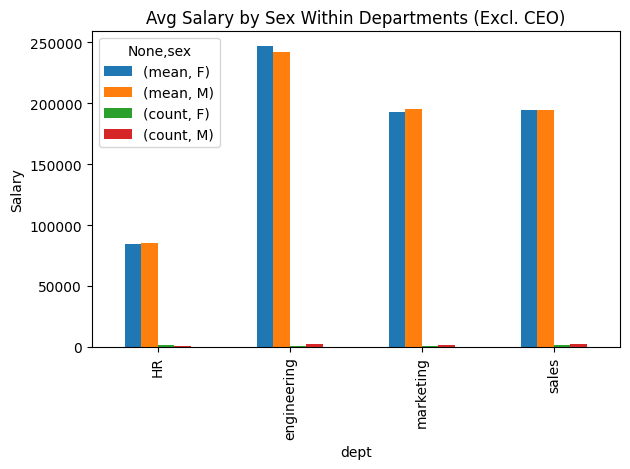

In [ ]:
import matplotlib.pyplot as plt

# Average salary by sex
average_salary_per_sex = employee.groupby("sex")["salary"].mean()
print("Average Salary by Sex:", average_salary_per_sex)
average_salary_per_sex.plot(kind="bar", title="Average Salary by Sex")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()

# Merge company_hierarchy and employee on employee_id
merged_df = pd.merge(company_hierarchy, employee, on="employee_id")

# Average salary per department
average_salary_per_dept = merged_df.groupby("dept")["salary"].mean().sort_values(ascending=False)
print("\nAverage Salary per Department:\n", average_salary_per_dept)
average_salary_per_dept.plot(kind="bar", title="Average Salary by Department")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()

# Average salary by employee level
average_salary_per_level = merged_df.groupby("employee_level")["salary"].mean().sort_values(ascending=False)
print("\nAverage Salary by Employee Level:\n", average_salary_per_level)
average_salary_per_level.plot(kind="bar", title="Average Salary by Employee Level")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()

# Average salary by degree level
average_salary_per_degree = merged_df.groupby("degree_level")["salary"].mean().sort_values(ascending=False)
print("\nAverage Salary per Degree Level:\n", average_salary_per_degree)
average_salary_per_degree.plot(kind="bar", title="Average Salary by Degree Level")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()

# Average salary by years of experience
average_salary_per_experience = merged_df.groupby("yrs_experience")["salary"].mean().sort_values(ascending=False)
print("\nAverage Salary per Years of Experience:\n", average_salary_per_experience)
average_salary_per_experience.plot(kind="bar", title="Average Salary by Years of Experience")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()

# Find the percentage of Male versus Female employees in each department
sex_percentage_per_dept = merged_df.groupby(["dept", "sex"]).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
print("\nPercentage of Male versus Female employees per Department:\n", sex_percentage_per_dept)
# Plot a bar graph
sex_percentage_per_dept.unstack().plot(kind="bar", stacked=True, title="Percentage of Male versus Female employees per Department")
plt.ylabel("Percentage")
plt.tight_layout()
plt.show()

# Exclude CEO department
filtered_df = merged_df[merged_df['dept'] != 'CEO']

# Stratified average salary by sex and department (excluding CEO)
grouped_salary = filtered_df.groupby(['dept', 'sex'])['salary'].agg(['mean', 'count'])
print(grouped_salary)

# Plot
grouped_salary.unstack().plot(kind='bar', title='Avg Salary by Sex Within Departments (Excl. CEO)')
plt.ylabel("Salary")
plt.tight_layout()
plt.show()


Looking into average salaries by different criteria we can gain some interesting insights:

Men make on average about $27K, 16% more than women.

The CEO as expected makes the most but out of the remaining departments Engineering pulls the highest salary, roughly $50K more than Sales and Marketing and almost $160k more than HR

Employee_level is very much as expected, the higher the level the igher the salary, this could be a great predictor in our model

When it comes to Degree_Level there is a suprisingly flat trend, PHDs on average only make $3,900 more than Bachelor degrees which is very small given the amount of extra school PHDs have

Looking at Yrs_Experience we notice there is a giant jump for employees over 20 years and younger employees salaries are relatively flat

A potential reason for men making more money is that a vast majority of the engineering jobs are held by men and engineering pays vastly more than any other department but interestingly enough when we look at average salary by department and gender we notice there is very little separation between men's and women's average salaries

Next step is run a simple linear regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define features and target
features = ["employee_level", "dept", "degree_level", "yrs_experience", "total_reports"]  # add 'sex' if you want
target = "salary"

# Drop rows with missing values in relevant columns
data = merged_df[features + [target]].dropna()

X = data[features]
y = data[target]

# Preprocessing: One-hot encode categorical columns
categorical_cols = ["employee_level", "dept", "degree_level"]
numeric_cols = ["yrs_experience", "total_reports"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
], remainder='passthrough')  # numeric columns are passed through

# Build pipeline
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance:")
print(f"MAE:  ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"R²:   {r2:.4f}")


Linear Regression Performance:
MAE:  $57,040.43
RMSE: $72,396.17
R²:   0.3678


Moderate performance: The model is explaining some salary variance, but not a majority.

This is expected from linear regression when:
The relationships are non-linear

There are interactions between features (e.g., experience × level)

You have outliers (like the CEO earning $700K)

This model didn't produce an accurate enough result so we are going to try Random Forest and see how that does

Statistical Evaluation:
  MAE : $57,627.58
  RMSE: $74,046.60
  R²  : 0.3387


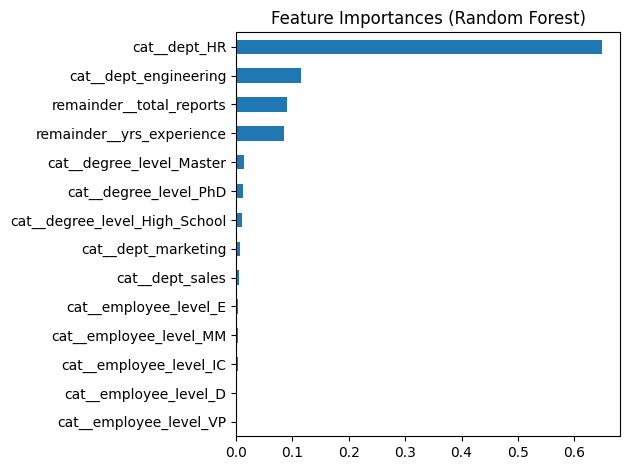


Practical Accuracy:
  % within ±25% of actual salary: 49.65%

Accuracy by Salary Band (±25%):
salary_band
<100K       0.466216
100-200K    0.423977
200-300K    0.768844
>300K       0.134545
Name: within_25pct, dtype: float64


/tmp/ipython-input-59-3525389273.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_accuracy = eval_df.groupby('salary_band')['within_25pct'].mean()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define features and target again if needed
features = ["employee_level", "dept", "degree_level", "yrs_experience", "total_reports"]
target = "salary"
data = merged_df[features + [target]].dropna()

X = data[features]
y = data[target]

categorical_cols = ["employee_level", "dept", "degree_level"]
numeric_cols = ["yrs_experience", "total_reports"]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), categorical_cols)
], remainder='passthrough')

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Split and fit
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Statistical Evaluation:")
print(f"  MAE : ${mae:,.2f}")
print(f"  RMSE: ${rmse:,.2f}")
print(f"  R²  : {r2:.4f}")

# Feature importances
importances = pipeline.named_steps['model'].feature_importances_
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
feat_importance_series = pd.Series(importances, index=feature_names).sort_values()

feat_importance_series.plot(kind='barh', title='Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

# Practical accuracy
relative_error = (y_pred / y_test - 1).abs()
accuracy_25pct = (relative_error < 0.25).mean()
print(f"\nPractical Accuracy:\n  % within ±25% of actual salary: {accuracy_25pct:.2%}")

# Salary band accuracy
eval_df = pd.DataFrame({
    'actual_salary': y_test,
    'predicted_salary': y_pred,
    'relative_error': relative_error
})
eval_df['salary_band'] = pd.cut(eval_df['actual_salary'], bins=[0, 100000, 200000, 300000, 1e6], labels=['<100K', '100-200K', '200-300K', '>300K'])
eval_df['within_25pct'] = eval_df['relative_error'] < 0.25

band_accuracy = eval_df.groupby('salary_band')['within_25pct'].mean()
print("\nAccuracy by Salary Band (±25%):")
print(band_accuracy)


Insights:

Department is the strongest predictor of salary.

HR appears to be significantly associated with lower salaries (negative importance is not shown directly, but you can infer from dominance).

Experience and number of reports matter, but to a lesser extent.

Employee level has surprisingly little influence, likely because it’s collinear with total_reports or department.

Salary Band	Accuracy
<100K	46.6%
100-200K	42.4%
200-300K	76.9% >300K	13.5%

The model does best in the middle salary bands.

High salaries (>300K) are the hardest to predict accurately — likely due to outliers or unique factors not captured in your features (e.g., negotiation, stock options, title inflation).

Low salaries show moderate predictive power — possibly more homogenous.

**Findings & Recommendations for Head of HR:**

1. **Department is the largest driver of salary**.
   - HR salaries are significantly lower than Engineering, Sales, and Marketing.
   - Employees in HR are more likely to be female, which explains much of the observed gender pay gap.

2. **Gender alone is not a strong predictor**.
   - When controlling for department, salary differences between men and women largely disappear.

3. **Employee level has surprisingly little predictive power**.
   - Consider standardizing compensation bands more clearly across titles.

4. **Salary growth appears nonlinear with experience**.
   - Employees may not see meaningful increases until they become senior. Review mid-level progression and compensation.

**Next Steps**:
- Review hiring pipeline to increase gender diversity in higher-paying departments.
- Evaluate if job responsibilities are aligned with titles across teams.
- Consider compensation equity review within departments.
